In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import graphviz

## Generalized Linear Models

**Linear Models**: Expected value is additive ("linear") combination of parameters

**Generalized Linear Models**: Expected value is some function of an additive combination of parameters

Uniform changes in predictor not uniform changes in prediction

All predictor variables interact, moderate one another

Influences predictions & uncertainty of predictions

Ceiling and floor effects, everything moderating everything else

## Confounded Admissions

Adding the confound of 'ability' (qualities of cand. that are difficult to measure that influence department and admission)

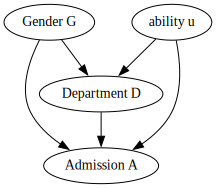

In [2]:
A = graphviz.Digraph()
A.edge('Gender G','Admission A')
A.edge('Gender G','Department D')
A.edge('Department D','Admission A')
A.edge('ability u','Department D')
A.edge('ability u','Admission A')
A

In [3]:
## Generative Sim

N = 2000
G = np.random.binomial(1,0.5,size=N)
U = np.random.binomial(1,0.1,size=N) #Sim high peeps

#Gender 0 tends to apply to dept 0, 1 to 1
D = np.random.binomial(1,[1*u if g==0 else 0.75 for g,u in zip(G,U)])
GD0 = np.histogram2d(G[U==0], D[U==0], bins=(2,2))[0]
GD1 = np.histogram2d(G[U==1], D[U==1], bins=(2,2))[0]

#Array of acceptance rates [dept,gender]

p_u0 = np.array([[0.1,0.1],[0.1,0.3]])
p_u1 = np.array([[0.3,0.5],[0.3,0.5]])
print('GD, U == 0')
print(GD0)
print('GD, U == 1')
print(GD1)

p_u = np.array([p_u0,p_u1])
# p_u = [ability,department,gender]
p    = np.array([p_u[U[i],D[i],G[i]] for i in range(N)])
A = np.random.binomial(1,p)

GD, U == 0
[[883.   0.]
 [237. 671.]]
GD, U == 1
[[ 0. 97.]
 [30. 82.]]


In [4]:
with pm.Model() as tot_sim:
    a = pm.Normal('a',0,1,shape=2)
    p =  pm.Deterministic("p", pm.invlogit(a[G]))
    likelihood = pm.Bernoulli('A',p,observed=A)
    tot_sim_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [5]:
with pm.Model() as direct_sim: #Confounded
    a = pm.Normal('a',0,1,shape=(2,2))
    p =  pm.Deterministic("p", pm.invlogit(a[G,D]))
    likelihood = pm.Bernoulli('A',p,observed=A)
    dir_sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [6]:
az.summary(tot_sim_trace)[:2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-2.062,0.101,-2.252,-1.878,0.001,0.001,4822.0,2706.0,1.0
a[1],-1.029,0.070,-1.163,-0.899,0.001,0.001,4105.0,2820.0,1.0


In [7]:
#In log odds
az.summary(dir_sim_trace)[:4]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-2.217,0.113,-2.440,-2.020,0.001,0.001,7261.0,3198.0,1.0
"a[0, 1]",-1.059,0.223,-1.494,-0.665,0.003,0.002,6848.0,3071.0,1.0
"a[1, 0]",-1.751,0.170,-2.069,-1.433,0.002,0.001,7635.0,3378.0,1.0
"a[1, 1]",-0.817,0.079,-0.971,-0.677,0.001,0.001,6903.0,3107.0,1.0


G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


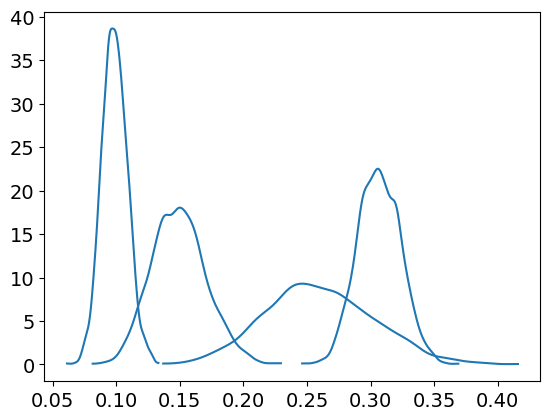

In [8]:
for i in range(2):
    for j in range(2):
        az.plot_kde(expit(dir_sim_trace.posterior.a.values[:,:,i,j]))
        
#Probability distribution of probabilities,
#for each deptartment:gender pair.
#Exceptional individuals of gender 1 don't apply to dept1
# So admission of applicants appear discriminated
#D2 has discrimination, but because ofthe ability, it has a 
# masking effect

In [9]:
A

array([0, 0, 0, ..., 0, 0, 0])

## Collider Bias

Stratifying by D opens non-causal path through u

Can estimate total causal effect of G, but isn't what we want

Cannot estimate direct effect of D or G. 

Intuitive explantion:

High ability G1s apply to discriminatory department anyway

G1s in that department are higher ability on average than G2s

High ability compensates for discrimination => masks evidence

Causal Foundations of bias, disparity and fairness

## Citation networks

Citation networks of members of NAS

Women associated with lower lifetime citation rate (G -> C)

## Membership

Election to NAS

Women associated with 3-15 times higher election rate, controlling for citations (C & G -> NAS Member M)

Not sre which one is true, need to be obvious with our causal assumptions otherwise we can't conlcude anything.

Plausible there are strong quality differences between those elected and not. Quality also effects citations.

Restrict smple to NAS members, examine citations.

If men less likely to be elected, then must have higher q,C to compensate

Control for citations, edamine elections to NAS. G is "treatment". C is a post-treatment variable! If women less likely to be cited (bias), then women more likely to be elected becase they have higher q than indicated by C. Citations is a post-treatment variable in this analysis. Activates the hidden quality, leads to a biased estimate of the effect of gender on election. e.g. if women are less likely to be cited, they are more likely to be elected because of their quality, the citations are misleading, they have compensated for the bias in citations. 



## No Causes in; No Causes Out - Nancy Cartwright

Hyped papers with vage estimands, unwise adjustment sets

Policy design through collider bias?

We can do better

Stronger assumptions required

Qualitative data useful, experts/experiencers are very useful in combination with administrative data

## Sensitivity analysis

What are the implications of what we don't know?

Assume confound exists, model its consequences for different strengths/kinds of influence

How strong must the confound be to change conclusions?

In [10]:
## Generative Sim
N = 2000
G = np.random.binomial(1,0.5,size=N)
U = np.random.binomial(1,0.1,size=N) #Sim high peeps

#Gender 0 tends to apply to dept 0, 1 to 1
D = np.random.binomial(1,[1*u if g==0 else 0.75 for g,u in zip(G,U)])

#Effects, simulating that they have different strengths, used to explore
# consequences of ability dfiferences
b = np.array([1,1])
g = np.array([1,0])

p_u = np.array([p_u0,p_u1])
# p_u = [ability,department,gender]
p    = np.array([p_u[U[i],D[i],G[i]] for i in range(N)])
A = np.random.binomial(1,p)

In [11]:
with pm.Model() as sens_m:    
    ## Generative Sim
    N = 2000
    G = np.random.binomial(1,0.5,size=N)
    U = np.random.binomial(1,0.1,size=N) #Sim high peeps

    #Gender 0 tends to apply to dept 0, 1 to 1
    D = np.random.binomial(1,[1*u if g==0 else 0.75 for g,u in zip(G,U)])

    #Effects, simulating that they have different strengths, used to explore
    # consequences of ability dfiferences
    b = np.array([1,1])
    g = np.array([1,0])
    
    #Array of acceptance rates [dept,gender]
    p_u0 = np.array([[0.1,0.1],[0.1,0.3]])
    p_u1 = np.array([[0.3,0.5],[0.3,0.5]])

    p_u = np.array([p_u0,p_u1])
    #p = [ability,department,gender]
    p    = np.array([p_u[U[i],D[i],G[i]] for i in range(N)])
    
    A = np.random.binomial(1,p)
    
    #D model
    u = pm.Normal('u',0,1,shape=N)
    delta = pm.Normal('G', 0,1,shape=2)
    q = delta[G] + g[G]*u
    
    D2 = pm.Bernoulli('D2',logit_p = q, observed = D)
    
    #A model
    a = pm.Normal('a', 0,1,shape = (2,2))
    p = a[G,D] + b[G]*u
    A = pm.Bernoulli('A',logit_p = p,observed=A)
    
    sens_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, G, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [12]:
az.summary(sens_trace)[-10:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u[1996],0.567,0.883,-0.969,2.305,0.010,0.014,6945.0,2343.0,1.0
u[1997],-0.274,0.894,-1.920,1.485,0.011,0.016,6526.0,2554.0,1.0
u[1998],-0.267,0.922,-2.086,1.395,0.011,0.017,7538.0,2692.0,1.0
u[1999],-0.190,0.934,-1.985,1.533,0.013,0.017,5606.0,2410.0,1.0
G[0],-2.351,0.110,-2.567,-2.158,0.001,0.001,6115.0,2979.0,1.0
G[1],1.070,0.073,0.933,1.210,0.001,0.001,8055.0,2291.0,1.0
"a[0, 0]",-2.417,0.123,-2.638,-2.179,0.002,0.001,5444.0,3116.0,1.0
"a[0, 1]",-1.559,0.227,-1.974,-1.124,0.003,0.002,6022.0,3050.0,1.0
"a[1, 0]",-2.145,0.199,-2.508,-1.756,0.003,0.002,6213.0,2733.0,1.0
"a[1, 1]",-0.913,0.095,-1.088,-0.738,0.001,0.001,6344.0,3085.0,1.0


Text(0, 0.5, 'Density')

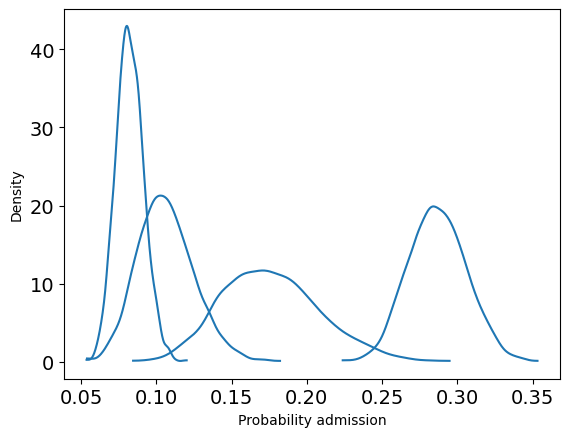

In [13]:
for i in range(2):
    for j in range(2):
        az.plot_kde(expit(sens_trace.posterior.a.values[:,:,i,j]))
plt.xlabel('Probability admission')
plt.ylabel('Density')
# Here we assume the confound
# Probaility for average ability applications. can see the discrimation now
# That was previously covered bby the confound. 

#In a real study you would be able to show how big the confound would need
# to be to reverse it sometimes this might be physically impossible!

## Sensitivity Analysis

**What are the implications of what we don't know?**

Somewhere between pure simulation and pure analysis

Vary confound strength over range and show how results changes -or- vary other effects and estimate confound strength 

Confounds persist - don't pretend. 

In [14]:
# 2006 parameters, more parameters than observations
az.summary(sens_trace).shape

(2006, 9)

The minimum number of samples for a bayesian analysis is 0 (can simulate from the prior!) and update with 1 sample is a luxury. 

## Oceanic Technology

How is technological complexity related to population size?

To social structure?

data(Kline)

**Estimand**: Influence of population size and contact on total tools


Idea is that the more people you have and the more contact you have the more innovations you have, and this causes more tools to arise. Societies also lose tools over time. 

Adjustment set for P: L

Also want to stratify by C, to study interaction. 

## Modeling tools

Tool count is not binomial: No maximum

**Poisson distribution** : Very high maximum and very low probability of each success

Here: many many possible technologies, very few realized in any one place

## Poisson link is log

Poisson distribution takes shape from expected value (rate

Must be positive

Exponential scaling can be surprising! 

Need a higher average, lower variance (Normal(3,0.5)) becuase of exponentiating

In [15]:
kline = pd.read_csv('Data/kline.csv',sep=';')
kline

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


In [16]:
# much of the following is taken from:
# https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

In [17]:
#kline.contact.astype('category').cat.codes

#Intercept only model
with pm.Model() as intercept_m:
    a = pm.Normal('a',3,0.5)
    T = pm.Poisson('T', pm.math.exp(a),observed = kline['total_tools'])
    intercept_trace = pm.sample()
    pm.sample_posterior_predictive(intercept_trace,extend_inferencedata=True)
    pm.compute_log_likelihood(intercept_trace) #Needed for comparison later

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [T]


In [18]:
# Interaction model
with pm.Model() as interact_m:

    #Model expects diminishing returns from pop size so we log it
    P = pm.MutableData('P',scale(np.log(kline['population'])))
    cid = pm.MutableData('cid',kline.contact.astype('category').cat.codes)
    b = pm.Normal('b',0,0.2,shape=2)
    a = pm.Normal('a',3,0.5,shape=2)
    
    lamb = pm.math.exp(a[cid] + b[cid]*P)
    T = pm.Poisson('T',lamb,observed= kline['total_tools'],shape=P.shape) # Need to set shape so that you can change it later
    
    interact_trace = pm.sample()
    pm.sample_posterior_predictive(interact_trace,extend_inferencedata=True)
    pm.compute_log_likelihood(interact_trace) #Needed for comparison later

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [T]


In [19]:
compare_dict = {'intercept_only': intercept_trace,'with_interact':interact_trace}

az.compare(compare_dict)
#Notice warning about 'highly influential observations'

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_interact,0,-42.277614,6.682400,0.000000,0.960358,6.108511,0.000000,True,log
intercept_only,1,-70.718590,8.104473,28.440976,0.039642,16.031149,15.972779,True,log


In [20]:
# store pareto-k values for plot:
k = az.loo(interact_trace, pointwise=True).pareto_k.values
k

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


array([0.29457267, 0.44945622, 0.26806043, 0.66467096, 0.21529679,
       0.4578958 , 0.25973585, 0.33079848, 0.62571758, 0.78863831])

In [21]:
interact_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [22]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns)

with interact_m:
    #Predictions for cid=0 (low contact)
    pm.set_data({'cid':np.array([0] * ns),"P": P_seq})
    lam0 = pm.sample_posterior_predictive(interact_trace, var_names=["T"])[
        "posterior_predictive"][
        "T"]
    #Predictions for cid=1 (high contact)
    pm.set_data({'cid':np.array([1]*ns),"P": P_seq})
    lam1 = pm.sample_posterior_predictive(interact_trace, var_names=["T"])[
        "posterior_predictive"][
        "T"]
    lmu0 = lam0.mean(["chain", "draw"])
    lmu1 = lam1.mean(["chain", "draw"])
    
    

Sampling: [T]


Sampling: [T]


Text(0.5, 0, 'population (log)')

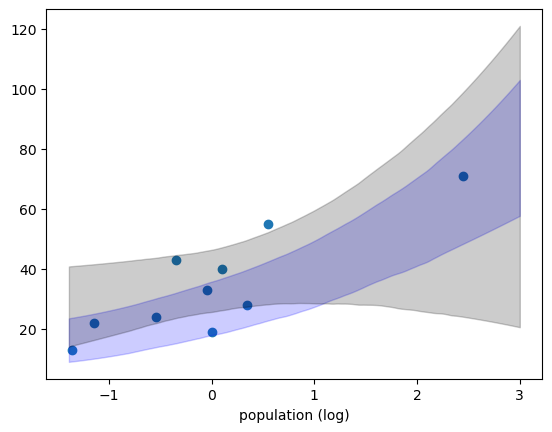

In [23]:

plt.scatter(x=scale(np.log(kline['population'])), y=kline['total_tools'])
az.plot_hdi(x=P_seq,y=lam1, color='b',hdi_prob=.89, fill_kwargs={"alpha":0.2})

az.plot_hdi(x=P_seq,y=lam0, color='k',hdi_prob=.89, fill_kwargs={"alpha":0.2})
plt.xlabel('population (log)')

(0.0, 120.0)

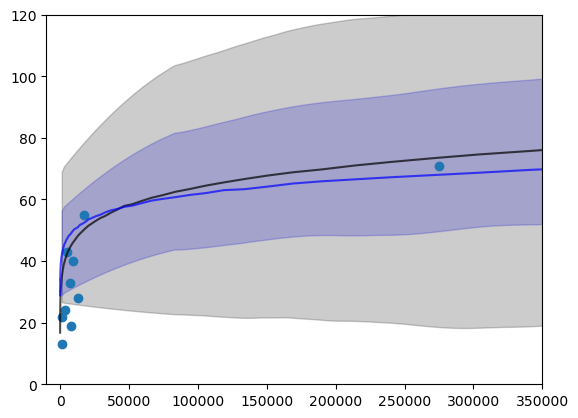

In [24]:
#Natural scale
P_seq = np.linspace(-5.0,3.0,ns)
P_seq = np.exp(P_seq * np.log(kline['population'].values).std() + np.log(kline['population'].values).mean())

az.plot_hdi(P_seq,lam1,color='b', fill_kwargs={"alpha":0.2})
az.plot_hdi(P_seq,lam0,color='k', fill_kwargs={"alpha":0.2})

plt.plot(P_seq,lmu1, color='k', alpha=0.7, label="high contact mean")
plt.plot(P_seq,lmu0, color='b', alpha=0.7, label="low contact mean")
plt.scatter(kline['population'],y=kline['total_tools'])
plt.xlim((-10000,350000))
plt.ylim((0,120))

#Note weird crossing, hawaii pulling things up. 
#Free intercept is also weird. Look at 0 on X axis. 

## This model is wack

Two ways to improve the model

1) Use a robust model: gamma-Poisson (neg-binomial). Poisson equivalent of stdent-T normal distribution. Will reduce influence of hawaii

2) A principled scientific model 

Writing a difference equation. T is one generation

$\Delta T  = \alpha_C P^{\beta_C} - \gamma T$

$\alpha$ = innovation rate

$\beta$ = diminishing returns (elasticity)

$\gamma$ = rate of loss

Difference equation: Says how tools change, not expected number

What is the equilibrium number of tools for different parameter values

$\hat{T} = \frac{\alpha_C P^{\beta_C}}{\gamma}$


In [25]:
def diff_eq(a=0.02,b=0.5,g=0.2,P=10000,t_max=50):
    T = [0]
    for i in range(1,t_max):
        T.append(T[i-1] + a*P**b - g*T[i-1])

    return T
y = diff_eq()

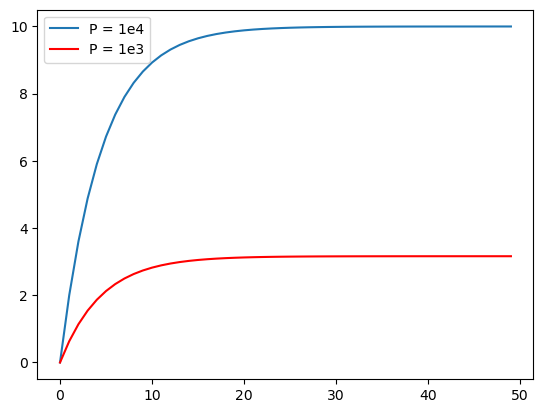

In [26]:
plt.plot(range(50),y,label='P = 1e4')
plt.plot(range(50),diff_eq(P=1000), label='P = 1e3',c='r')
plt.legend()

#Notive flatlines

In [27]:
kline

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


Solving for equilibrium T (when T=0)
T = (ac * P ^Bc)/gamma

In [28]:
with pm.Model() as loss_m:
    #data
    tools = pm.MutableData('tools',kline['total_tools'])
    #This standardization is taken from notes previously linked
    #Has to do with fixing the scale and enforcing positive values for P
    P     = scale(np.log(kline['population']))
    P     = P + np.abs(P.min()) + 0.1 #A small epsilon 
    P     = pm.MutableData('P', P)
    Cid   = pm.MutableData('Cid', kline['contact'].astype('category').cat.codes)
    
    g     = pm.Exponential('g',1)
    b     = pm.Exponential('b',1,shape=2)
    a     = pm.Normal('a',1,1,shape=2)
    
    lamb  = (pm.math.exp(a[Cid])*P**b[Cid])/g #a is exponentiated to force it to be positive
                                            #b is exponential prior as an alternative way
    
    T     = pm.Poisson('T',lamb,observed=tools, shape=P.shape)
    loss_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [29]:
az.summary(loss_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.411,0.726,0.075,2.751,0.023,0.017,961.0,1266.0,1.0
a[1],1.442,0.724,0.081,2.755,0.023,0.017,958.0,1198.0,1.0
g,0.177,0.136,0.020,0.421,0.004,0.003,958.0,1211.0,1.0
b[0],0.572,0.330,0.002,1.125,0.007,0.005,1571.0,981.0,1.0
b[1],0.463,0.073,0.335,0.605,0.002,0.001,1929.0,1690.0,1.0


array([[<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'g'}>,
        <AxesSubplot: title={'center': 'g'}>],
       [<AxesSubplot: title={'center': 'b'}>,
        <AxesSubplot: title={'center': 'b'}>]], dtype=object)

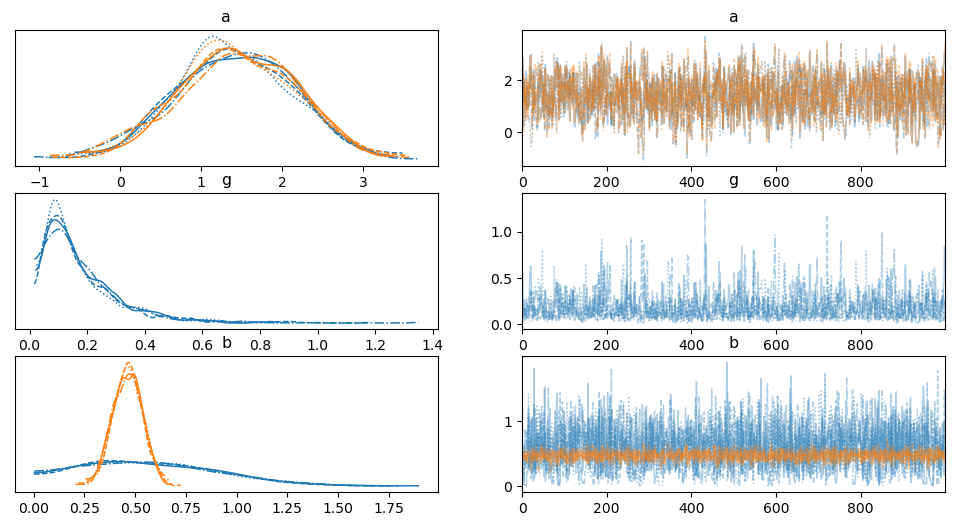

In [30]:
az.plot_trace(loss_trace)

In [31]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4

with loss_m:
    
#Predictions for cid=0 (low contact)
    pm.set_data({'Cid':np.array([0]*ns),"P": P_seq})
    lam0 = pm.sample_posterior_predictive(loss_trace, var_names=["T"])[
        "posterior_predictive"][
        "T"]
    #Predictions for cid=1 (high contact)
    pm.set_data({'Cid':np.array([1]*ns),"P": P_seq})
    lam1 = pm.sample_posterior_predictive(loss_trace, var_names=["T"])[
        "posterior_predictive"][
        "T"]
    lmu0 = lam0.mean(["chain", "draw"])
    lmu1 = lam1.mean(["chain", "draw"])

Sampling: [T]


Sampling: [T]


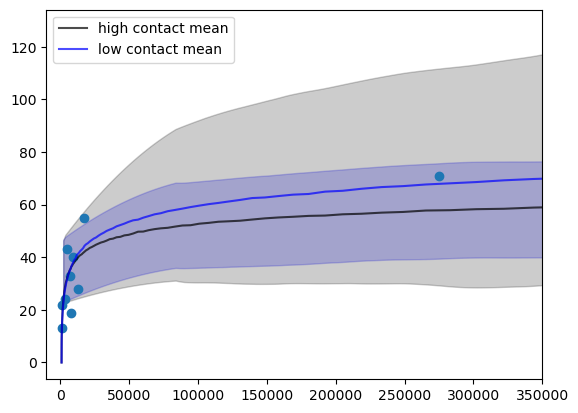

In [32]:
#Natural scale
#P_seq = np.linspace(-5.0,3.0,ns)
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4

P_seq = np.exp(
    (P_seq - 1.4) * np.log(kline.population.values).std() + np.log(kline.population.values).mean()
)
az.plot_hdi(P_seq,lam1,color='b', fill_kwargs={"alpha":0.2})
az.plot_hdi(P_seq,lam0,color='k', fill_kwargs={"alpha":0.2})

plt.plot(P_seq,lmu1, color='k', alpha=0.7, label="high contact mean")
plt.plot(P_seq,lmu0, color='b', alpha=0.7, label="low contact mean")
plt.scatter(kline['population'],y=kline['total_tools'])
plt.xlim((-10000,350000))
#plt.ylim((0,120))
plt.legend()

#Note weird crossing, hawaii pulling things up. 
#Free intercept is also weird. Look at 0 on X axis. 

## Count GLMs

Often bounded, the ceiling and floor effects affect the causal effect of changing any variable (makes them smaller as you approach limits)

Distributions from constraints

Maximum entropy priors: Binomial, Poisson, and extensions

More event types: Multinomial and categorical

Robust regressions: Beta-binomial, gamma-Poisson. Introduce unobserved heterogeneity. Reduce over fitting


## Simpson's Pandora's Box

Simpson's paradox: Reversal of an association when groups are combined or separated in the dataset

No way to know which association combined/separated) is correct without causal assumptions

## Berkeley Paradox

Unconditional on department: Women admitted at lower rate

Conditional on department: Women admitted slightly more

Which is correct? no way to know without assumptions

Mediator(department)

Collider+confound(ability)

## Non-linear haunting

In event models, effect reversal can arise other ways

Example: Base rate differences 

X -> Y
Z -> Y


In [33]:
N = 1000
X = np.random.normal(size=N)
Z = np.random.binomial(1,0.5,size=N)
p = expit([X-1 if Z==1 else X+5 for X,Z in zip(X,Z)])
Y = np.random.binomial(1,p)

with pm.Model() as rate_m:
    b = pm.Normal('b',0,1)
    a = pm.Normal('a',0,1)
    p = pm.math.invlogit(a + b*X)
    Yobs = pm.Bernoulli('Yobs',p,observed=Y)
    rate_trace = pm.sample()
    rate_post = pm.sample_posterior_predictive(rate_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [Yobs]


In [34]:
with pm.Model() as ratez_m:
    b = pm.Normal('b',0,1,shape=2)
    a = pm.Normal('a',0,1)
    p = pm.math.invlogit(a + b[Z]*X)
    Yobs = pm.Bernoulli('Yobs',p,observed=Y)
    ratez_trace = pm.sample()
    ratez_post = pm.sample_posterior_predictive(ratez_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [Yobs]


In [35]:
rate_post.posterior_predictive.Yobs

<xarray.DataArray 'Yobs' (chain: 4, draw: 1000, Yobs_dim_2: 1000)>
array([[[1, 0, 1, ..., 1, 1, 0],
        [1, 0, 1, ..., 0, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [0, 1, 0, ..., 1, 0, 1],
        [1, 1, 0, ..., 1, 1, 0],
        [1, 1, 0, ..., 1, 0, 0]],

       [[0, 1, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 1, 0, 0],
        ...,
        [1, 1, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 1, ..., 1, 0, 1],
        [1, 0, 0, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 1]],

       [[0, 1, 0, ..., 0, 1, 0],
        [0, 1, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 0, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]]], dtype=int64)
Coordinates:
  * chain       (chain) int32 0 1 2 3
  * draw        (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * Yobs_dim_2  (Yobs_dim_2) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

Still figuring out how to plot these things



In [36]:
#az.plot_hdi(X,rate_post.posterior_predictive.Yobs)
rate_ppc = (rate_post.posterior_predictive.Yobs).stack(sample=("chain", "draw"))

#plt.plot(X,rate_ppc[:,:1])
#rate_ppc.shape


Just because a posterior distribution overlaps 0, you don't accept the null. You can reject nulls, but you can't accept them. 

## Simpson's Pandora's Box

No paradox, because almost anything can produce it

People do not have intuitions about coefficient reversals

Stop naming statistical paradoxes; start teaching scientific logic. 